In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import gc
import time

# Base functions

## Data loader

In [2]:
class DataLoaderWrap:
    def __init__(self, batch = 64):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        self.train_data = datasets.MNIST(
            root="./data",
            train=True,
            transform=transform,
            download=True
        )

        self.test_data = datasets.MNIST(
            root="./data",
            train=False,
            transform=transform,
            download=True
        )

        self.train_loader = DataLoader(
            self.train_data,
            batch_size=batch,
            shuffle=True
            )

        self.test_loader = DataLoader(
            self.test_data,
            batch_size=batch,
            shuffle=False
            )


## Trainer

In [3]:
class ModelUtils:
    def __init__(self, model, learning_rate=0.001):
        self.model = model

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )

        self.model.to(self.device)

        self.criterion = nn.CrossEntropyLoss()

        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=learning_rate
        )

    def train(self, train_loader, test_loader, epochs):
        self.model.train()
        self.training_losses = []
        self.validation_losses = []

        for epoch in range(epochs):
            running_loss = 0.0
            for inputs, labels in train_loader:

                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                self.optimizer.zero_grad()

                outputs = self.model(inputs)

                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

            avg_training_loss = running_loss / len(train_loader)
            self.training_losses.append(avg_training_loss)

            val_loss = 0.0

            self.model.eval()
            with torch.no_grad():
                for val_inputs, val_labels in test_loader:
                    val_inputs, val_labels = val_inputs.to(self.device), val_labels.to(self.device)
                    val_outputs = self.model(val_inputs)
                    val_loss += self.criterion(val_outputs, val_labels).item()

            avg_validation_loss = val_loss / len(test_loader)
            self.validation_losses.append(avg_validation_loss)
            self.model.train()

            print(f"Epoch {epoch + 1}, Training Loss: {avg_training_loss}, Validation Loss: {avg_validation_loss}")

    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for inputs, labels in test_loader:

                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        accuracy = 100 * correct / total
        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        f1 = f1_score(all_labels, all_predictions, average='weighted')

        print(f"Accuracy: {accuracy}%")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")

    def predict(self, image):
        self.model.eval()
        image = image.to(self.device)
        with torch.no_grad():
            output = self.model(image.unsqueeze(0))
            _, predicted = torch.max(output.data, 1)
        return predicted.item()

    def save_model(self, file_path):
        torch.save(self.model.state_dict(), file_path)
        print(f"Model saved to {file_path}")

    def load_model(self, file_path):
        self.model.load_state_dict(torch.load(file_path))
        self.model.to(self.device)
        print(f"Model loaded from {file_path}")

    def remove_model(self):
        self.model.to('cpu')
        del self.model
        gc.collect()
        torch.cuda.empty_cache() 


# Models

## LeNet

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


## AlexNet

In [5]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


## 28x28 AlexNet

In [6]:
class AlexNet28(nn.Module):
    def __init__(self):
        super(AlexNet28, self).__init__()
        self.features = nn.Sequential(
            # заменил первый и 3 слой
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## VGG16

In [6]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc14 = nn.Linear(25088, 4096)
        self.fc15 = nn.Linear(4096, 4096)
        self.fc16 = nn.Linear(4096, 10)

    def forward(self, x):
        x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        x = nn.functional.leaky_relu(self.conv1(x))
        x = nn.functional.leaky_relu(self.conv2(x))
        x = self.maxpool(x)
        x = nn.functional.leaky_relu(self.conv3(x))
        x = nn.functional.leaky_relu(self.conv4(x))
        x = self.maxpool(x)
        x = nn.functional.leaky_relu(self.conv5(x))
        x = nn.functional.leaky_relu(self.conv6(x))
        x = nn.functional.leaky_relu(self.conv7(x))
        x = self.maxpool(x)
        x = nn.functional.leaky_relu(self.conv8(x))
        x = nn.functional.leaky_relu(self.conv9(x))
        x = nn.functional.leaky_relu(self.conv10(x))
        x = self.maxpool(x)
        x = nn.functional.leaky_relu(self.conv11(x))
        x = nn.functional.leaky_relu(self.conv12(x))
        x = nn.functional.leaky_relu(self.conv13(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = nn.functional.leaky_relu(self.fc14(x))
        x = nn.functional.dropout(x, 0.5)
        x = nn.functional.leaky_relu(self.fc15(x))
        x = nn.functional.dropout(x, 0.5)
        x = self.fc16(x)
        return x

## 28x28 VGG13

In [7]:
class VGG13(nn.Module):
    def __init__(self):
        super(VGG13, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc11 = nn.Linear(4608, 1024)
        self.fc12 = nn.Linear(1024, 1024)
        self.fc13 = nn.Linear(1024, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = self.maxpool(x)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        x = self.maxpool(x)
        x = nn.functional.relu(self.conv5(x))
        x = nn.functional.relu(self.conv6(x))
        x = nn.functional.relu(self.conv7(x))
        x = self.maxpool(x)
        x = nn.functional.relu(self.conv8(x))
        x = nn.functional.relu(self.conv9(x))
        x = nn.functional.relu(self.conv10(x))

        x = x.reshape(x.shape[0], -1)
        x = nn.functional.relu(self.fc11(x))
        x = nn.functional.dropout(x, 0.5)
        x = nn.functional.relu(self.fc12(x))
        x = nn.functional.dropout(x, 0.5)
        x = self.fc13(x)
        return x

# Inference

## LeNet

In [ ]:
data = DataLoaderWrap(batch = 128)
lenet = ModelUtils(LeNet(), learning_rate=0.001)

In [10]:
epochs=10

lenet.train(data.train_loader, data.test_loader, epochs=epochs)
lenet.save_model("lenet_model.pth")

Epoch 1, Training Loss: 0.35181599628251753, Validation Loss: 0.09079909639114726
Epoch 2, Training Loss: 0.07939858566215044, Validation Loss: 0.06527760363761571
Epoch 3, Training Loss: 0.057626355776011245, Validation Loss: 0.04089439547395251
Epoch 4, Training Loss: 0.046205684682652196, Validation Loss: 0.04239608027052747
Epoch 5, Training Loss: 0.03704032651099092, Validation Loss: 0.04051326209446415
Epoch 6, Training Loss: 0.03138624378112651, Validation Loss: 0.03230375599304341
Epoch 7, Training Loss: 0.027315492110539363, Validation Loss: 0.0378674496264754
Epoch 8, Training Loss: 0.023726588924294276, Validation Loss: 0.03786230267037872
Epoch 9, Training Loss: 0.021449968415393886, Validation Loss: 0.03110334365274993
Epoch 10, Training Loss: 0.017786045780969855, Validation Loss: 0.03860952992372519
Model saved to lenet_model.pth


Accuracy: 98.88%
Precision: 0.9888385652128316
Recall: 0.9888
F1 Score: 0.9888001822097026


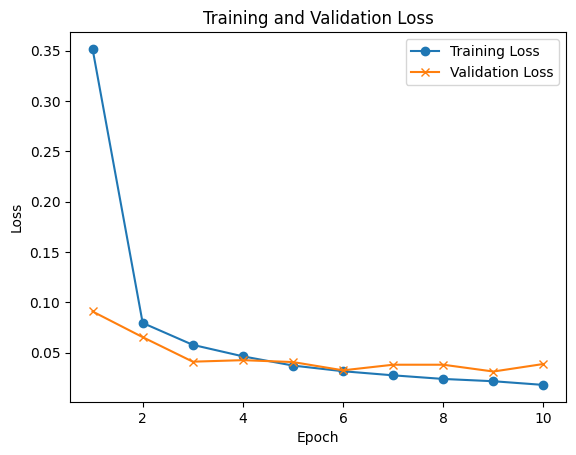

In [12]:
lenet.evaluate(data.test_loader)

lenet_training_losses = lenet.training_losses
lenet_validation_losses = lenet.validation_losses

plt.plot(range(1, epochs + 1), lenet_training_losses, label='Training Loss', marker='o')
plt.plot(range(1, epochs + 1), lenet_validation_losses, label='Validation Loss', marker='x')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Predicted Label: 7


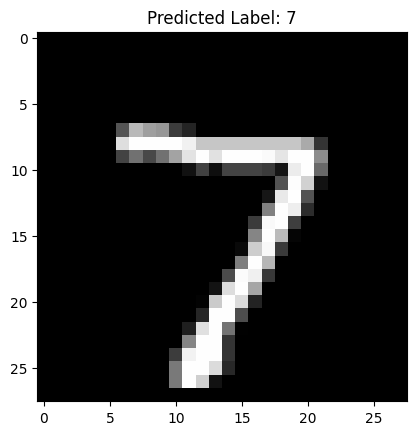

In [13]:
example_image, _ = next(iter(data.test_loader))
example_image = example_image[0]
predicted_label = lenet.predict(example_image)
print(f"Predicted Label: {predicted_label}")

plt.imshow((example_image.squeeze().numpy()), cmap="gray")
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

In [14]:
lenet.remove_model()

## AlexNet

In [15]:
data = DataLoaderWrap(batch = 128)
alexnet = ModelUtils(AlexNet(), learning_rate=0.001)

In [16]:
epochs=10

alexnet.train(data.train_loader, data.test_loader, epochs=epochs)
alexnet.save_model("alexnet_model.pth")

Epoch 1, Training Loss: 0.35031193592893417, Validation Loss: 0.062476815985916534
Epoch 2, Training Loss: 0.08826261787200725, Validation Loss: 0.04361949477984299
Epoch 3, Training Loss: 0.06612828408312331, Validation Loss: 0.044435109763186646
Epoch 4, Training Loss: 0.06609074883103402, Validation Loss: 0.035900187771841056
Epoch 5, Training Loss: 0.054291365373291885, Validation Loss: 0.022598962100772363
Epoch 6, Training Loss: 0.05397020983246606, Validation Loss: 0.02859845350721565
Epoch 7, Training Loss: 0.049842373539965706, Validation Loss: 0.032820295054344695
Epoch 8, Training Loss: 0.046595537130892685, Validation Loss: 0.023730250334769085
Epoch 9, Training Loss: 0.043792844356806165, Validation Loss: 0.026376540719405667
Epoch 10, Training Loss: 0.0396955150459061, Validation Loss: 0.026770660219133074
Model saved to alexnet_model.pth


Accuracy: 99.21%
Precision: 0.9921402771036987
Recall: 0.9921
F1 Score: 0.9920916835451989


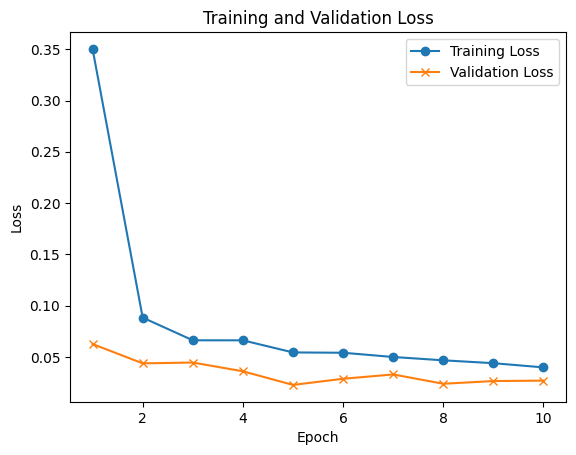

In [17]:
alexnet.evaluate(data.test_loader)

alexnet_training_losses = alexnet.training_losses
alexnet_validation_losses = alexnet.validation_losses

plt.plot(range(1, epochs + 1), alexnet_training_losses, label='Training Loss', marker='o')
plt.plot(range(1, epochs + 1), alexnet_validation_losses, label='Validation Loss', marker='x')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Predicted Label: 2


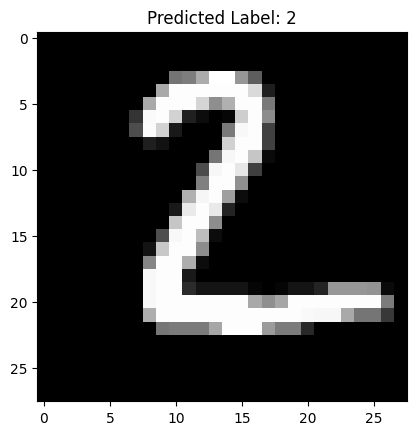

In [18]:
example_image, _ = next(iter(data.test_loader))
example_image = example_image[1]
predicted_label = alexnet.predict(example_image)
print(f"Predicted Label: {predicted_label}")

plt.imshow((example_image.squeeze().numpy()), cmap="gray")
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

In [19]:
alexnet.remove_model()

## AlexNet_28

In [20]:
data = DataLoaderWrap(batch = 128)
alexnet28 = ModelUtils(AlexNet28(), learning_rate=0.001)

In [21]:
epochs=10

alexnet28.train(data.train_loader, data.test_loader, epochs=epochs)
alexnet28.save_model("alexnet28_model.pth")

Epoch 1, Training Loss: 0.4295869660831845, Validation Loss: 0.0885746138217517
Epoch 2, Training Loss: 0.08928111341964605, Validation Loss: 0.036427766490374734
Epoch 3, Training Loss: 0.07202322508738652, Validation Loss: 0.03683072296663812
Epoch 4, Training Loss: 0.0593181027711105, Validation Loss: 0.03557041513667622
Epoch 5, Training Loss: 0.05433802587736739, Validation Loss: 0.031559274340722795
Epoch 6, Training Loss: 0.04920479140630655, Validation Loss: 0.036224857778633344
Epoch 7, Training Loss: 0.04440898209354028, Validation Loss: 0.041572673100653205
Epoch 8, Training Loss: 0.04779574952856786, Validation Loss: 0.02968474821377237
Epoch 9, Training Loss: 0.03903731796629866, Validation Loss: 0.029133097323394877
Epoch 10, Training Loss: 0.03668891477062484, Validation Loss: 0.026514496816254236
Model saved to alexnet28_model.pth


Accuracy: 99.16%
Precision: 0.9916536568687552
Recall: 0.9916
F1 Score: 0.9916005813271503


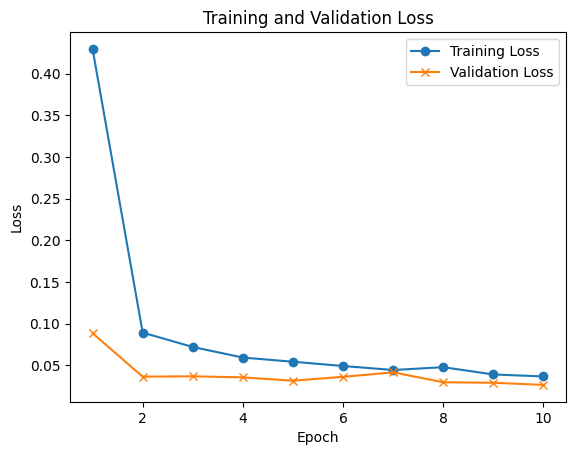

In [22]:
alexnet28.evaluate(data.test_loader)

alexnet28_training_losses = alexnet28.training_losses
alexnet28_validation_losses = alexnet28.validation_losses

plt.plot(range(1, epochs + 1), alexnet28.training_losses, label='Training Loss', marker='o')
plt.plot(range(1, epochs + 1), alexnet28.validation_losses, label='Validation Loss', marker='x')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Predicted Label: 1


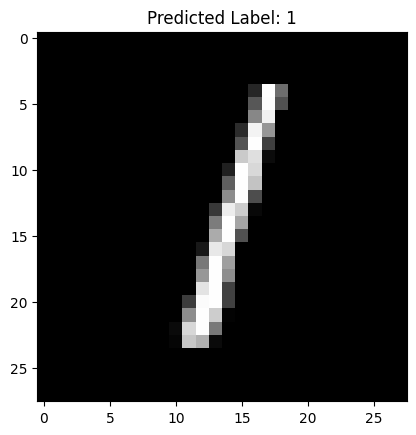

In [23]:
example_image, _ = next(iter(data.test_loader))
example_image = example_image[2]
predicted_label = alexnet28.predict(example_image)
print(f"Predicted Label: {predicted_label}")
plt.imshow((example_image.squeeze().numpy()), cmap="gray")
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

In [24]:
alexnet28.remove_model()

## Comparison of AlexNet and AlexNet_28

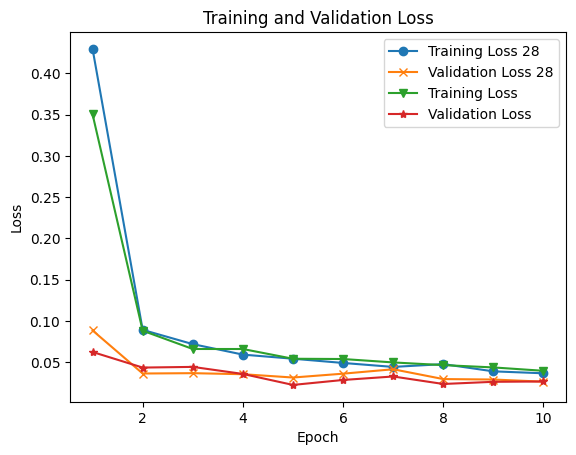

In [25]:
plt.plot(range(1, epochs + 1), alexnet28_training_losses, label='Training Loss 28', marker='o')
plt.plot(range(1, epochs + 1), alexnet28_validation_losses, label='Validation Loss 28', marker='x')
plt.plot(range(1, epochs + 1), alexnet_training_losses, label='Training Loss', marker='v')
plt.plot(range(1, epochs + 1), alexnet_validation_losses, label='Validation Loss', marker='*')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## VGG16

In [ ]:
data = DataLoaderWrap(batch = 128)
vgg = ModelUtils(VGG16(), learning_rate=0.0001)

In [9]:
epochs=10

vgg.train(data.train_loader, data.test_loader, epochs=epochs)
vgg.save_model("vgg_model.pth")

Epoch 1, Training Loss: 1.6384220235810305, Validation Loss: 0.1107587265688926
Epoch 2, Training Loss: 0.07137894259106058, Validation Loss: 0.03389964284346206
Epoch 3, Training Loss: 0.040946003999173024, Validation Loss: 0.033251887912324495
Epoch 4, Training Loss: 0.030514975893408215, Validation Loss: 0.044651567501132375
Epoch 5, Training Loss: 0.024584238527792575, Validation Loss: 0.031689524722214625
Epoch 6, Training Loss: 0.020071039583356955, Validation Loss: 0.024569810204216082
Epoch 7, Training Loss: 0.017664396766679906, Validation Loss: 0.022552738400281668
Epoch 8, Training Loss: 0.01436167447032858, Validation Loss: 0.02676661142500734
Epoch 9, Training Loss: 0.01149874101876018, Validation Loss: 0.032050277061771694
Epoch 10, Training Loss: 0.01138134517322584, Validation Loss: 0.024385801534362202
Model saved to vgg_model.pth


Accuracy: 99.29%
Precision: 0.9929177801316204
Recall: 0.9929
F1 Score: 0.9929007205318592


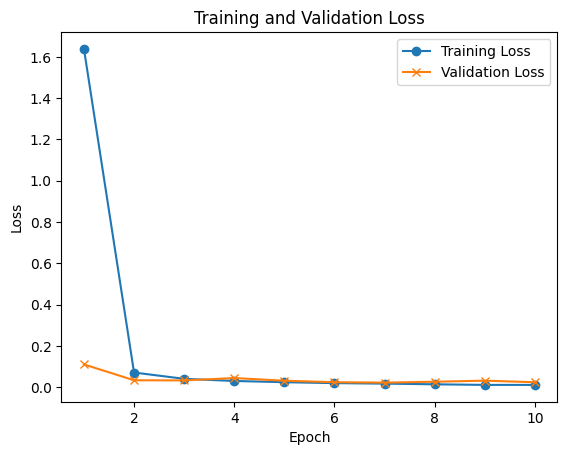

In [10]:
vgg.evaluate(data.test_loader)

vgg_training_losses = vgg.training_losses
vgg_validation_losses = vgg.validation_losses

plt.plot(range(1, epochs + 1), vgg_training_losses, label='Training Loss', marker='o')
plt.plot(range(1, epochs + 1), vgg_validation_losses, label='Validation Loss', marker='x')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Predicted Label: 0


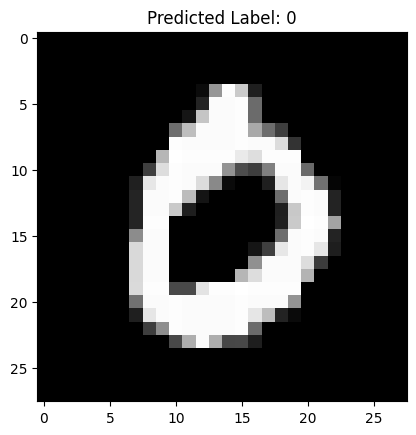

In [12]:
example_image, _ = next(iter(data.test_loader))
example_image = example_image[3]
predicted_label = vgg.predict(example_image)
print(f"Predicted Label: {predicted_label}")

plt.imshow((example_image.squeeze().numpy()), cmap="gray")
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

In [13]:
vgg.remove_model()

## VGG13_28

In [ ]:
data = DataLoaderWrap(batch = 128)
vgg28 = ModelUtils(VGG13(), learning_rate=0.0001)

In [10]:
epochs=10

vgg28.train(data.train_loader, data.test_loader, epochs=epochs)
vgg28.save_model("vgg13_model.pth")

Epoch 1, Training Loss: 0.8648086939007044, Validation Loss: 0.1469213794125244
Epoch 2, Training Loss: 0.11454354604085286, Validation Loss: 0.06401945769437589
Epoch 3, Training Loss: 0.07425765043124556, Validation Loss: 0.07348261028761044
Epoch 4, Training Loss: 0.05271614435090063, Validation Loss: 0.05211668838543119
Epoch 5, Training Loss: 0.040538017199820996, Validation Loss: 0.0462061154760886
Epoch 6, Training Loss: 0.0335172526036816, Validation Loss: 0.030058492819371167
Epoch 7, Training Loss: 0.027527890212343968, Validation Loss: 0.03047114755754592
Epoch 8, Training Loss: 0.025767148841914604, Validation Loss: 0.03423776545163491
Epoch 9, Training Loss: 0.02233526608348863, Validation Loss: 0.03206856010474439
Epoch 10, Training Loss: 0.01941463781930603, Validation Loss: 0.029880642180287395
Model saved to vgg13_model.pth


Accuracy: 99.26%
Precision: 0.9926260542842942
Recall: 0.9926
F1 Score: 0.9926007649578904


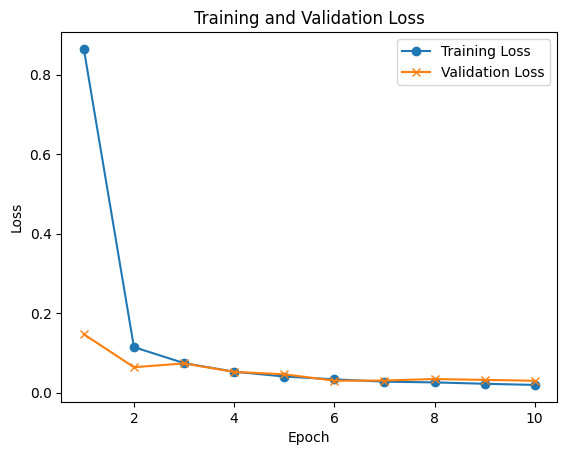

In [11]:
vgg28.evaluate(data.test_loader)

vgg28_training_losses = vgg28.training_losses
vgg28_validation_losses =vgg28.validation_losses

plt.plot(range(1, epochs + 1), vgg28_training_losses, label='Training Loss', marker='o')
plt.plot(range(1, epochs + 1), vgg28_validation_losses, label='Validation Loss', marker='x')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Predicted Label: 4


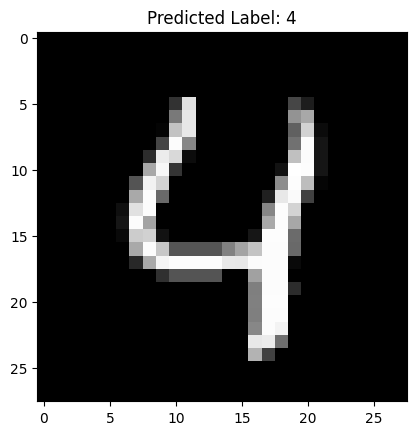

In [14]:
example_image, _ = next(iter(data.test_loader))
example_image = example_image[4]
predicted_label = vgg28.predict(example_image)
print(f"Predicted Label: {predicted_label}")

plt.imshow((example_image.squeeze().numpy()), cmap="gray")
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

In [15]:
vgg28.remove_model()

## Comparison of VGG16 and VGG13

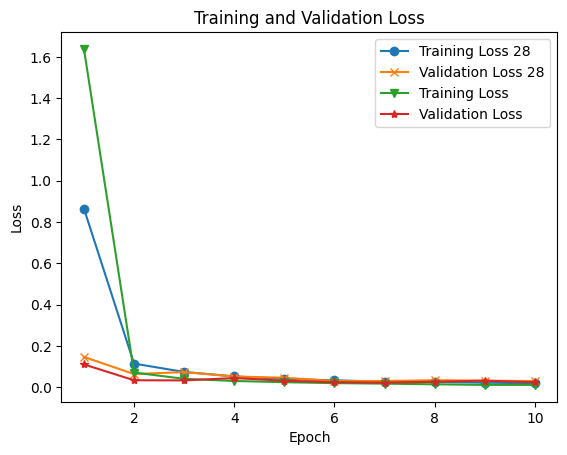

In [16]:
plt.plot(range(1, epochs + 1), vgg28_training_losses, label='Training Loss 28', marker='o')
plt.plot(range(1, epochs + 1), vgg28_validation_losses, label='Validation Loss 28', marker='x')
plt.plot(range(1, epochs + 1), vgg_training_losses, label='Training Loss', marker='v')
plt.plot(range(1, epochs + 1), vgg_validation_losses, label='Validation Loss', marker='*')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

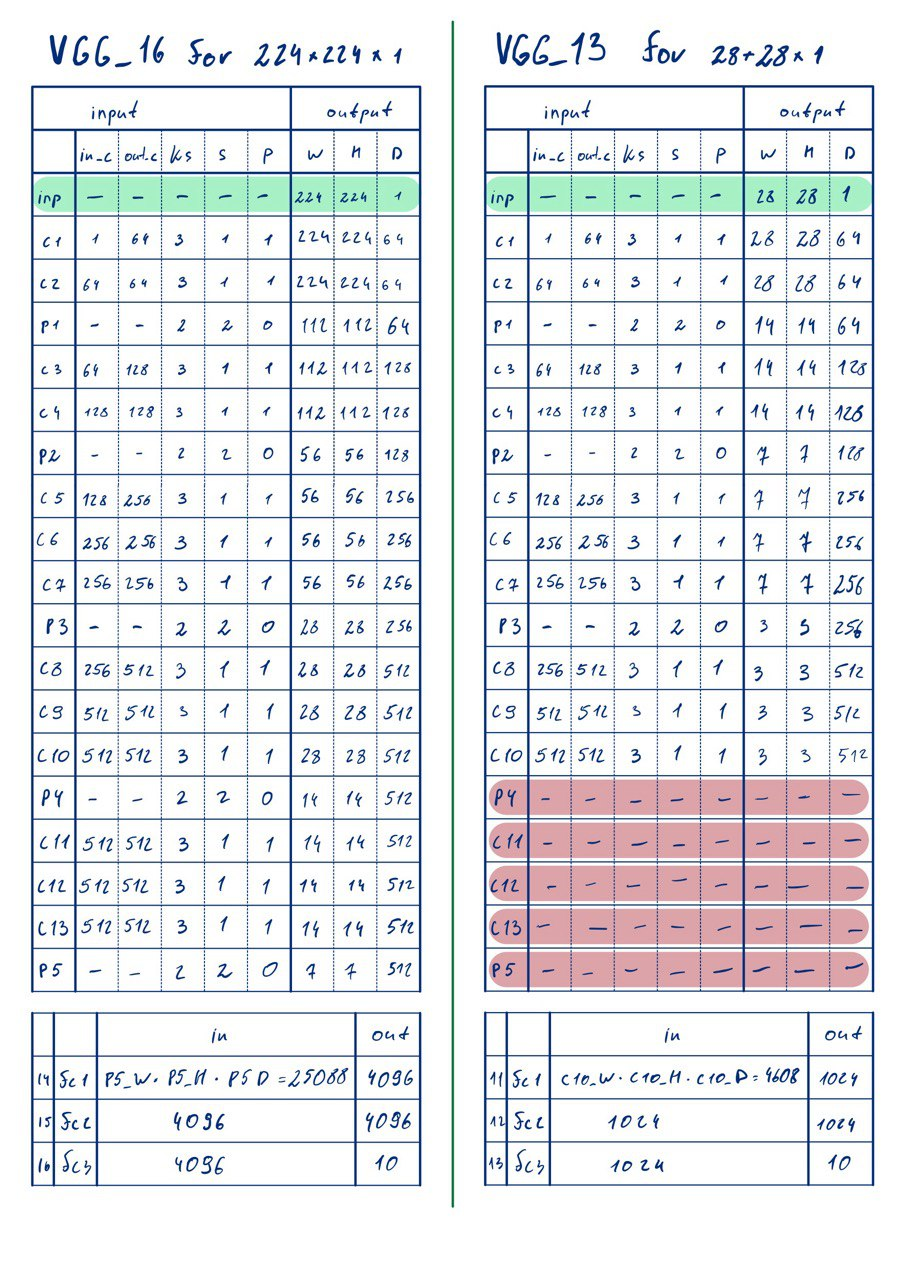
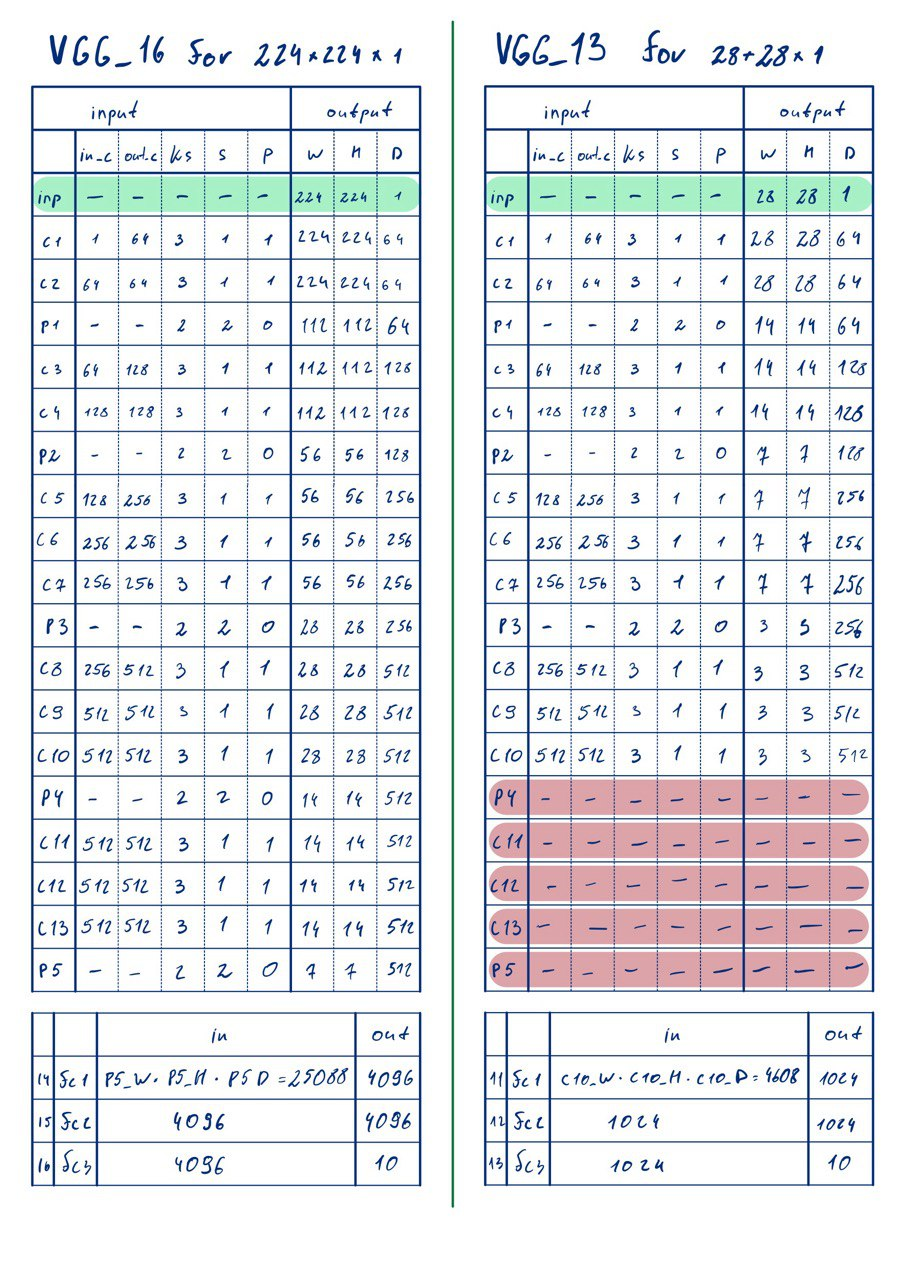